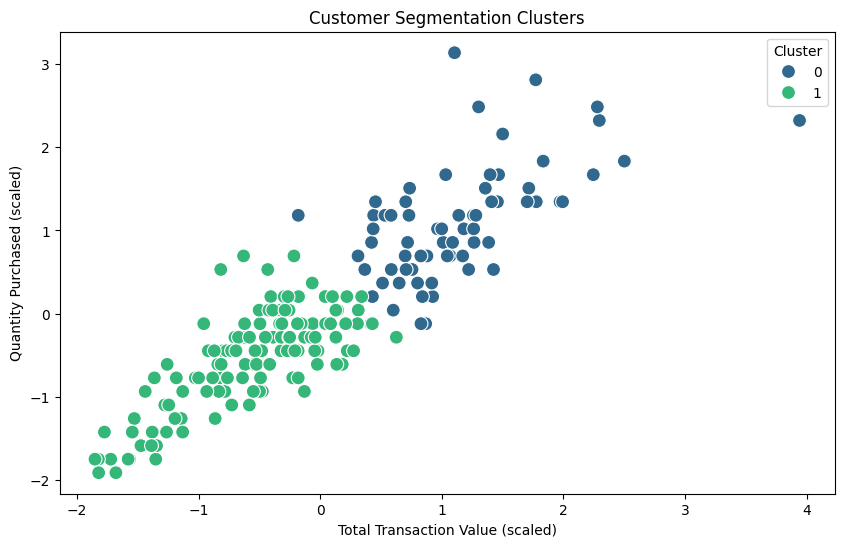

Optimal Number of Clusters: 2
Davies-Bouldin Index for Optimal Clusters: 0.6267041632486106
Customer segmentation completed and saved to Customer_Segments.csv.


In [1]:
# Customer Segmentation using Clustering

# Importing Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Datasets
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')

# Merging Datasets
customer_transactions = transactions.merge(customers, on='CustomerID')

# Feature Engineering
# Aggregating transaction data for clustering
customer_profiles = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
}).reset_index()

# Adding profile information (e.g., region encoding)
if 'Region' in customers.columns:
    region_dummies = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'], drop_first=True)
    customer_profiles = customer_profiles.merge(region_dummies, on='CustomerID', how='left')

# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity']
scaled_features = scaler.fit_transform(customer_profiles[numerical_features])
customer_profiles[numerical_features] = scaled_features

# Clustering with KMeans
# Choosing the number of clusters between 2 and 10
cluster_metrics = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_profiles[numerical_features])
    db_index = davies_bouldin_score(customer_profiles[numerical_features], cluster_labels)
    cluster_metrics.append((n_clusters, db_index))

# Selecting the optimal number of clusters based on DB Index
optimal_clusters = min(cluster_metrics, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles[numerical_features])

# Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_profiles['TotalValue'],
    y=customer_profiles['Quantity'],
    hue=customer_profiles['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Transaction Value (scaled)')
plt.ylabel('Quantity Purchased (scaled)')
plt.legend(title='Cluster')
plt.show()

# Reporting Clustering Metrics
print("Optimal Number of Clusters:", optimal_clusters)
print("Davies-Bouldin Index for Optimal Clusters:", min(cluster_metrics, key=lambda x: x[1])[1])

# Saving Cluster Assignments
customer_profiles.to_csv('Customer_Segments.csv', index=False)
print("Customer segmentation completed and saved to Customer_Segments.csv.")
